# Load everything

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os,sys,glob
from math import *
import xarray as xr
import pickle
import pytz
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy import optimize

In [2]:
# Load own modules
projectname = 'EUREC4A_organization'
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
while os.path.basename(rootdir) != projectname:
    rootdir = os.path.dirname(rootdir)
repodir = rootdir
moduledir = os.path.join(repodir,'functions')
resultdir = os.path.join(repodir,'results','idealized_calculations')
figdir = os.path.join(repodir,'figures','idealized_calculations')
inputdir = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
resultinputdir = os.path.join(repodir,'results','radiative_features')
radinputdir = os.path.join(repodir,'input')
scriptsubdir = 'automated_moist_intrusions'

os.makedirs(os.path.join(figdir,scriptsubdir),exist_ok=True)

In [3]:
# current environment
thismodule = sys.modules[__name__]

##-- Own modules
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

#- Parameters & constants
from thermoConstants import *
from thermoFunctions import *
from matrixoperators import *
from radiativefeatures import *
from radiativescaling import *

mo = MatrixOperators()

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats', 'thermoFunctions', 'thermoConstants', 'radiativescaling', 'radiativefeatures', 'matrixoperators']


## Load data

In [4]:
rad_file_MI_20200213 = os.path.join(radinputdir,'rad_profiles_moist_intrusions_20200213.nc')
radprf_MI_20200213 = xr.open_dataset(rad_file_MI_20200213)

In [5]:
radprf_MI_20200213.name

<xarray.DataArray 'name' (index: 9)>
array(['reference', 'id', 'id_rl', 'id_ru', 'id_rul', 'idf', 'idf_rl',
       'idf_ru', 'idf_rul'], dtype=object)
Coordinates:
    lay      int32 ...
    col      int32 ...
  * index    (index) int64 0 1 1 1 1 2 2 2 2

# Take upper intrusion from 2020-02-13 and redistribute it

In [6]:
radprf_MI_20200213.play

<xarray.DataArray 'play' (play: 1000)>
array([100000.,  99900.,  99800., ...,    300.,    200.,    100.])
Coordinates:
    lay      int32 ...
    col      int32 ...
  * play     (play) float64 1e+05 9.99e+04 9.98e+04 ... 300.0 200.0 100.0
Attributes:
    units:    Pa

In [7]:
## functions


def getIdealizedProf(radprf_id,varids,i_id):

    z_id = radprf_id.zlay[i_id]/1e3

    temp_id = radprf_id.tlay[i_id]
    qv_id = radprf_id.qv[i_id]
    rh_id = radprf_id.rh[i_id]
    qvstar_id = qv_id/rh_id

    return z_id,temp_id,qv_id,qvstar_id,rh_id

def waterPath(qv,pres,p_bottom):

    p_increasing = np.diff(pres)[0] > 0

    if p_increasing:

        arr = qv
        p = pres

    else:

        arr = np.flip(qv)
        p = np.flip(pres)

    p0 = p[0]
    p1 = p_bottom

    return mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)


def computeWPaboveZ(qv,pres):
    """Calculates the integrated water path above each level.

    Arguments:
        - qv: specific humidity in kg/kg, Nz matrix
        - pres: pressure coordinate in hPa, Nz vector

    returns:
        - wp_z: water path above each level, Nz matrix"""

    Np = qv.shape[0]
    wp_z = np.full(Np,np.nan)

    p_increasing = np.diff(pres)[0] > 0

    for i_p in range(Np-2):
        # self.wp_z[:,i_z] = self.mo.pressureIntegral(arr=data.specific_humidity[:,i_z:],pres=pres[i_z:],p_levmin=pres[i_z],p_levmax=pres[-1],z_axis=z_axis)

        if p_increasing:

            arr = qv
            p = pres
            p0 = p[0]
            p1 = p[i_p]
            i_w = i_p

        else:

            arr = np.flip(qv)
            p = np.flip(pres)
            p0 = p[0]
            p1 = p[i_p]
            i_w = Np-i_p-1

        wp_z[i_w] = mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)

    return wp_z

def saturatedWaterPath(temp,pres,p_bottom):

    p_increasing = np.diff(pres)[0] > 0

    if p_increasing:

        p = pres
        arr = saturationSpecificHumidity(temp,p*hPa_to_Pa)

    else:

        p = np.flip(pres)
        arr = saturationSpecificHumidity(np.flip(temp),p*hPa_to_Pa)
        
    p0 = p[0]
    p1 = p_bottom

    return mo.pressureIntegral(arr=arr,pres=p,p0=p0,p1=p1)


def piecewise_linear(z,z_breaks,rh_breaks):
    
    Nb = len(z_breaks)
    
    cond_list = [z <= z_breaks[0]]+\
                [np.logical_and(z > z_breaks[i-1],z <= z_breaks[i]) for i in range(1,Nb)]+\
                [z > z_breaks[Nb-1]]
    def make_piece(k):
        def f(z):
            return rh_breaks[k-1]+(rh_breaks[k]-rh_breaks[k-1])/(z_breaks[k]-z_breaks[k-1])*(z-z_breaks[k-1])
        return f 
    func_list = [lambda z: rh_breaks[0]]+\
                [make_piece(k) for k in range(1,Nb)]+\
                [lambda z: rh_breaks[Nb-1]]
    
    return np.piecewise(z,cond_list,func_list)

def z2p(z_0,z,pres):
    """Assume z is increasing"""
    
    i_z = np.where(z>=z_0)[0][0]
    
    return pres[i_z]
    

check @ 800 hPa:
Refence water path spread (before, after): 2.859060739834756 1.9616140879310566
Water path with moist layer spread (before, after): 4.442881409363754 3.0482803818007165
Water path with moist layer rectangular: 3.5594050115726126


Text(0.5, 0.98, '       ')

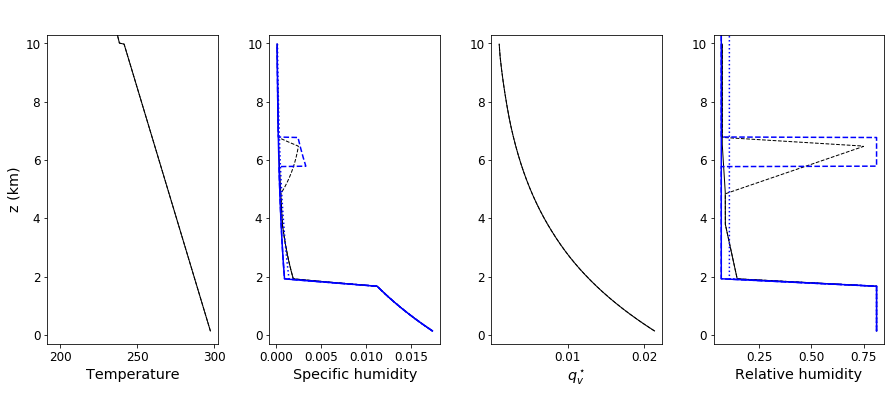

In [8]:
i_ref = 4
i_mi = 2

hPa_to_Pa = 1e2
p_jump = 800 # hPa
rh_max = 0.85
pres = radprf_MI_20200213.play/hPa_to_Pa # hPa
z = np.array(radprf_MI_20200213.zlay[i_ref]/1e3) # km
qvstar = radprf_MI_20200213.qv[i_ref]/radprf_MI_20200213.rh[i_ref]

varids = 'temp','qv','qvstar','rh'
Nv = len(varids)

#-- compute W with and without intrusion

W_ref = waterPath(radprf_MI_20200213.qv[i_ref],pres,p_jump)
W_mi = waterPath(radprf_MI_20200213.qv[i_mi],pres,p_jump)

#-- Flatten RH for dry profile with/without intrusion

Wsat = saturatedWaterPath(radprf_MI_20200213.tlay[i_ref],pres,p_jump)
rh_min_ref = W_ref/Wsat
rh_min_mi = W_mi/Wsat

#-- Reconstruct profile with uniform free troposphere
def reconstructConstantRH(rh_min):
    
    # original piecewise parameters
    params_20200213 = np.array([1.66883978, 1.92184357, 3.78683593, 4.84246134, 6.47640954,
           6.77508558, 0.81134813, 0.14594506, 0.7024782 , 0.08932133,
           0.75291206, 0.07457219])
    z_breaks_20200213 = params_20200213[:6]
    rh_breaks_20200213 = params_20200213[6:]
    # profiles
    z_breaks = z_breaks_20200213[:2]
    rh_breaks = np.array([rh_breaks_20200213[0],rh_min])
    rh_prof = piecewise_linear(z,z_breaks,rh_breaks)
    
    return rh_prof

rh_ref = reconstructConstantRH(rh_min_ref)
rh_mi = reconstructConstantRH(rh_min_mi)

#-- Reconstruct rectangle intrusions in RH-z space
# Get intrusion mass
W_int = W_mi - W_ref
# Add rectangle intrusion to constant RH
def addIntrusionToProfile(pres,qvstar,rh_prof,W_int,p_int,rh_max):
    """Add moisture intrusion as a rectangle in RH"""
    
    #-- find vertical extent of intrusion
    # q deficit (RH to RHmax)
    delta_qv_prof = (rh_max-rh_prof)*qvstar
    mask_above_intrusion = (pres < p_int).data
    delta_qv_prof[mask_above_intrusion] = 0
    
    # water path down to watch level
    Wdqv = computeWPaboveZ(delta_qv_prof,pres)
    # levels where W is below water path of intrusion
    mask_intrusion_and_above = (Wdqv < W_int).data
    mask_intrusion = np.logical_and(mask_intrusion_and_above,
                                    np.logical_not(mask_above_intrusion))
    #-- create resulting RH profile
    rh_out = rh_prof.copy()
    rh_out[mask_intrusion] = rh_max
    
    return rh_out


p_int = z2p(6.77,z,pres)
rh_mi_rect = addIntrusionToProfile(pres,qvstar,rh_ref,W_int,p_int,rh_ref[0])

#- equivalent specific humidities
qv_ref = rh_ref*qvstar
qv_mi = rh_mi*qvstar
qv_mi_rect = rh_mi_rect*qvstar

#-- check water paths
W_ref_check = waterPath(qv_ref,pres,p_jump)
W_mi_check = waterPath(qv_mi,pres,p_jump)
W_mi_rect_check = waterPath(qv_mi_rect,pres,p_jump)

print('check @',p_jump,'hPa:')
print('Refence water path spread (before, after):',W_ref,W_ref_check)
print('Water path with moist layer spread (before, after):',W_mi,W_mi_check)
print('Water path with moist layer rectangular:',W_mi_rect_check)

#-- Show

radprf_all = radprf_MI_20200213,
col_all = 'k',
linewidth_all = 1,

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))

for radprf_xr,col,linewidth in zip(radprf_all,col_all,linewidth_all):

    vars_ref = getIdealizedProf(radprf_xr,varids,i_ref)
    vars_mi = getIdealizedProf(radprf_xr,varids,i_mi)
    Nv = len(varids)

    for i,var_ref,var_mi in zip(range(Nv),vars_ref[1:],vars_mi[1:]):

        axs[i].plot(var_ref,vars_ref[0],c=col,linewidth=linewidth)
        axs[i].plot(var_mi,vars_mi[0],c=col,linewidth=linewidth,linestyle='--')
        axs[i].set_ylim((-0.3,10.3))

for suffix,linestyle in zip(('_ref','_mi','_mi_rect'),('-',':','--')):
    
    for i_ax,varid in zip((1,3),('qv','rh')):
        
        var = getattr(thismodule,"%s%s"%(varid,suffix))
        axs[i_ax].plot(var,z,c='b',linestyle=linestyle)

axs[0].set_xlabel('Temperature')
axs[1].set_xlabel('Specific humidity')
axs[2].set_xlabel(r'$q_v^\star$')
axs[3].set_xlabel('Relative humidity')
axs[0].set_ylabel('z (km)')

# axs[1].set_xlim((-10,3))
plt.suptitle('       ')


# Vary height and water path of intrusion

Import radiative calculation for profiles created with script

    /Users/bfildier/Code/analyses/EUREC4A/EUREC4A_rad_profiles/scripts/createIdealizedMoistureProfiles_RectangleMoistIntrusions.py

In [9]:
rad_file = os.path.join(radinputdir,'rad_profiles_rectangular_moist_intrusions.nc')
rad_file_h2oOnly = os.path.join(radinputdir,'rad_profiles_rectangular_moist_intrusions_h2oOnly.nc')

radprf = xr.open_dataset(rad_file)
radprf_h2oOnly = xr.open_dataset(rad_file_h2oOnly)

In [44]:
radprf.name.data[:8]

array(['ref', 'ref_uniform_RH', 'ref_moist_intrusion',
       'ref_moist_intrusion_uniform_RH',
       'ref_moist_intrusion_rectangular_RH', 'W_3.48mm_uniform_RH',
       'W_3.79mm_uniform_RH', 'W_4.10mm_uniform_RH'], dtype=object)

In [ ]:
print("check if RH and Qrad make sense for idealized cases")

from itertools import product

W_range = W_all[0], W_all[-3]
H_range = H_all[0], H_all[-1]

inds2show = 

Nprof = len(inds2show)

z = radprf.zlay[0]/1e3 # km

#-- Show

varids = 'h2o','q_rad_lw'
Nv = len(varids)
cols = 'k','g','g','b','b'
linestyles = '-','-','--','-','--'
linewidths = 2,1.5,1.5,0.5,0.5

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))

for i_ax in range(Nv):
    
    ax = axs.flatten()[i_ax]
    varid = varids[i_ax]
    
    ax.plot(radprf[varid].data[0],z,c=cols[0],linewidth=linewidths[0],linestyle=linestyles[0])
    
    for i_prof in range(1,1+Nprof):
        
        var = radprf[varid].data[inds_4corners[i_prof-1]]
        col = cols[i_prof]
        linewidth = linewidths[i_prof]
        linestyle = linestyles[i_prof]
        
        ax.plot(var,z,c=col,linewidth=linewidth,linestyle=linestyle)

    ax.set_ylim((-0.3,10.3))
        
axs[0].set_xlabel('Specific humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')


In [12]:
print("define indices of idealized profiles")

Nsample = 20

inds_id = slice(0,5)
inds_uniformRH = slice(5,25)
inds_varyWandRH = slice(25,None)

W_all = [float(str(radprf.name[inds_uniformRH][i].data)[2:6]) for i in range(Nsample)]
H_all = [float(str(radprf.name[inds_uniformRH.stop:inds_uniformRH.stop+Nsample][i].data)[11:15]) for i in range(Nsample)]

print('W_all:',W_all)
print('H_all:',H_all)

define indices of idealized profiles
W_all: [3.48, 3.79, 4.1, 4.41, 4.73, 5.04, 5.35, 5.66, 5.98, 6.29, 6.6, 6.91, 7.23, 7.54, 7.85, 8.16, 8.48, 8.79, 9.1, 9.42]
H_all: [3.0, 3.37, 3.74, 4.11, 4.47, 4.84, 5.21, 5.58, 5.95, 6.32, 6.68, 7.05, 7.42, 7.79, 8.16, 8.53, 8.89, 9.26, 9.63, 10.0]


check if RH and Qrad make sense for extreme cases


Text(0, 0.5, 'z (km)')

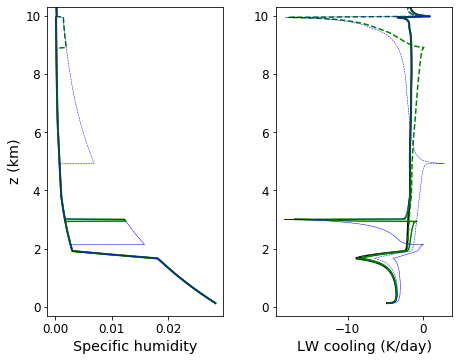

In [13]:
print("check if RH and Qrad make sense for extreme cases")

from itertools import product

W_range = W_all[0], W_all[-3]
H_range = H_all[0], H_all[-1]

name_4corners = ['W_%2.2fmm_H_%1.2fkm'%(W,H) for W,H in product(W_range,H_range)]
inds_4corners = np.where(np.isin(radprf.name.data,name_4corners))[0]

Nprof = len(name_4corners)

z = radprf.zlay[0]/1e3 # km

#-- Show

varids = 'h2o','q_rad_lw'
Nv = len(varids)
cols = 'k','g','g','b','b'
linestyles = '-','-','--','-','--'
linewidths = 2,1.5,1.5,0.5,0.5

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))

for i_ax in range(Nv):
    
    ax = axs.flatten()[i_ax]
    varid = varids[i_ax]
    
    ax.plot(radprf[varid].data[0],z,c=cols[0],linewidth=linewidths[0],linestyle=linestyles[0])
    
    for i_prof in range(1,1+Nprof):
        
        var = radprf[varid].data[inds_4corners[i_prof-1]]
        col = cols[i_prof]
        linewidth = linewidths[i_prof]
        linestyle = linestyles[i_prof]
        
        ax.plot(var,z,c=col,linewidth=linewidth,linestyle=linestyle)

    ax.set_ylim((-0.3,10.3))
        
axs[0].set_xlabel('Specific humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')


check how RH and Qrad change for varying intrusion heights


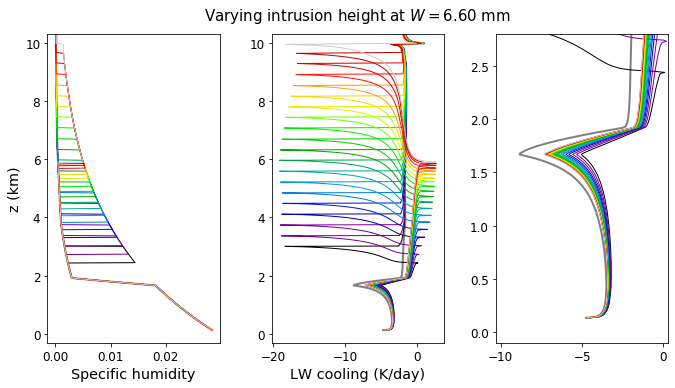

In [14]:
print("check how RH and Qrad change for varying intrusion heights")

from itertools import product

i_W = 10
W = W_all[i_W]
H_range = H_all[0], H_all[-1]

names = ['W_%2.2fmm_H_%1.2fkm'%(W,H) for H in H_all]
inds = np.where(np.isin(radprf.name.data,names))[0]

Nprof = len(name_4corners)

z = radprf.zlay[0]/1e3 # km

#-- Show

varids = 'h2o','q_rad_lw','q_rad_lw'
Nv = len(varids)
linestyles = '-','-'
linewidths = 2,1

# cols
var_col = H_all
norm = matplotlib.colors.Normalize(vmin=H_range[0], vmax=H_range[1])
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col),bytes=True)/255

fig,axs = plt.subplots(ncols=Nv,figsize=(4*Nv-0.5,5.5))

for i_ax in range(Nv):
    
    ax = axs.flatten()[i_ax]
    varid = varids[i_ax]
    
    ax.plot(radprf[varid].data[0],z,c='grey',linewidth=linewidths[0],linestyle=linestyles[0])
    
    for i_prof in range(len(H_all)):
        
        var = radprf[varid].data[inds[i_prof],:]
        col = cols[i_prof]
        
        ax.plot(var,z,c=col,linewidth=linewidths[1],linestyle=linestyles[1])


for ax in axs[:2]:
    ax.set_ylim((-0.3,10.3))

axs[2].set_ylim((-0.1,2.8))
axs[2].set_xlim((-10.3,0.3))
        
axs[0].set_xlabel('Specific humidity')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# suptitle at midpoint of left and right x-positions
mid = (fig.subplotpars.right + fig.subplotpars.left)/2
plt.suptitle(r'Varying intrusion height at $W=%1.2f$ mm'%W,fontsize=15,x=mid)

plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_W%1.2fmm.pdf'%W),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_W%1.2fmm.png'%W),bbox_inches='tight')

Effect of moist intrusions on the low-level peak


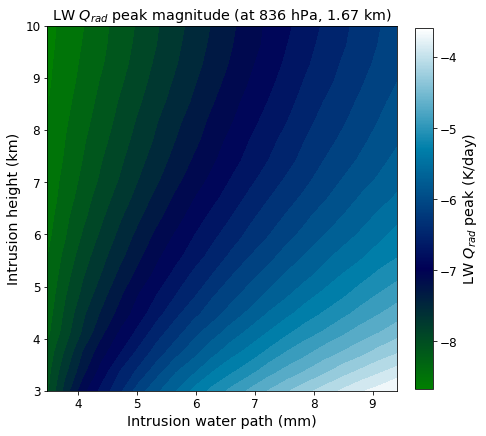

In [28]:
print('Effect of moist intrusions on the low-level peak')

# peak height
z_jump = 1.66883978
z = radprf.zlay[0]/1e3 # km
k_jump = np.where(z>=z_jump)[0][0]
pres_jump = radprf.play[k_jump]/1e2 # hPa

qradlw_peak = np.full((Nsample,Nsample),np.nan)

for i_W in range(Nsample):
    for i_H in range(Nsample):
        
        W = W_all[i_W]
        H = H_all[i_H]
        name = 'W_%2.2fmm_H_%1.2fkm'%(W,H)
        i_prof = np.where(np.isin(radprf.name.data,name))[0][0]
        
        qradlw_peak[i_W,i_H] = radprf.q_rad_lw[i_prof,k_jump].data


fig,ax = plt.subplots(figsize=(8,6.5))

# ax.imshow(qradlw_peak.T)
# cmap = plt.cm.BrBG_r
# cmap = plt.cm.cividis
# cmap = plt.cm.gnuplot2
cmap = plt.cm.ocean
vmin = np.min(qradlw_peak)
vmax = np.max(qradlw_peak)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
ax.contourf(W_all,H_all,qradlw_peak.T,levels=30,cmap=cmap,vmin=vmin,vmax=vmax)

# labels
ax.set_xlabel('Intrusion water path (mm)')
ax.set_ylabel('Intrusion height (km)')

# colorbar
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap),
                 ax=ax,shrink=0.99,pad=0.04)
cb.set_label(r'LW $Q_{rad}$ peak (K/day)')

ax.set_title(r'LW $Q_{rad}$ peak magnitude (at %3.0f hPa, %1.2f km)'%(pres_jump,z_jump))

plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_varyW.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_varyW.png'),bbox_inches='tight')

Effect of moist intrusions on the low-level peak


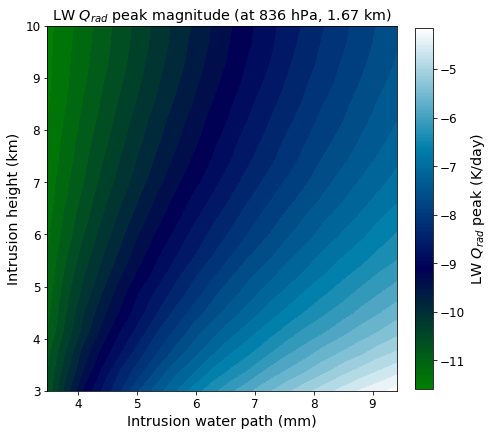

In [37]:
print('Effect of moist intrusions on the low-level peak')

##-- compute peak for H2O only

# peak height
z_jump = 1.66883978
z = radprf.zlay[0]/1e3 # km
k_jump = np.where(z>=z_jump)[0][0]
pres_jump = radprf.play[k_jump]/1e2 # hPa

qradlw_peak_h2oOnly = np.full((Nsample,Nsample),np.nan)

for i_W in range(Nsample):
    for i_H in range(Nsample):
        
        W = W_all[i_W]
        H = H_all[i_H]
        name = 'W_%2.2fmm_H_%1.2fkm'%(W,H)
        i_prof = np.where(np.isin(radprf.name.data,name))[0][0]
        
        qradlw_peak_h2oOnly[i_W,i_H] = radprf_h2oOnly.q_rad_lw[i_prof,k_jump].data

##-- show 

fig,ax = plt.subplots(figsize=(8,6.5))

# ax.imshow(qradlw_peak.T)
# cmap = plt.cm.BrBG_r
# cmap = plt.cm.cividis
# cmap = plt.cm.gnuplot2
cmap = plt.cm.ocean
vmin = np.min(qradlw_peak_h2oOnly)
vmax = np.max(qradlw_peak_h2oOnly)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
ax.contourf(W_all,H_all,qradlw_peak_h2oOnly.T,levels=30,cmap=cmap,vmin=vmin,vmax=vmax)

# labels
ax.set_xlabel('Intrusion water path (mm)')
ax.set_ylabel('Intrusion height (km)')

# colorbar
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap),
                 ax=ax,shrink=0.99,pad=0.04)
cb.set_label(r'LW $Q_{rad}$ peak (K/day)')

ax.set_title(r'LW $Q_{rad}$ peak magnitude (at %3.0f hPa, %1.2f km)'%(pres_jump,z_jump))

plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_varyW_h2oOnly.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_varyW_h2oOnly.png'),bbox_inches='tight')

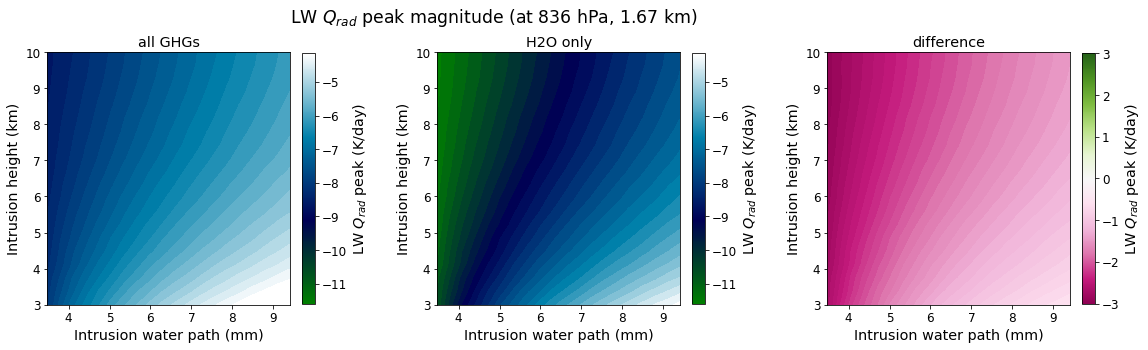

In [38]:
print('compare')

##-- show comparison with all GHGs

fig,axs = plt.subplots(ncols=3,figsize=(20,4.5))

cmap_lwqrad = plt.cm.ocean
vmin = np.nanmin(qradlw_peak_h2oOnly)
vmax = np.nanmax(qradlw_peak_h2oOnly)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

vars2show = qradlw_peak, qradlw_peak_h2oOnly, qradlw_peak_h2oOnly-qradlw_peak
titles = 'all GHGs', 'H2O only', 'difference'
vranges = (vmin,vmax), (vmin,vmax), (-3,3)
cmaps = cmap_lwqrad, cmap_lwqrad, plt.cm.PiYG

for ax,var,title,vrange,cmap in zip(axs,vars2show,titles,vranges,cmaps):

    vmin,vmax = vrange
    ax.contourf(W_all,H_all,var.T,levels=30,cmap=cmap,vmin=vmin,vmax=vmax)

    # labels
    ax.set_xlabel('Intrusion water path (mm)')
    ax.set_ylabel('Intrusion height (km)')

    # colorbar
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap),
                     ax=ax,shrink=0.99,pad=0.04)
    cb.set_label(r'LW $Q_{rad}$ peak (K/day)')

    ax.set_title(title)
    
plt.suptitle(r'LW $Q_{rad}$ peak magnitude (at %3.0f hPa, %1.2f km)'%(pres_jump,z_jump),y=1.05)

    
    
plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_varyW_w_wo_h2o.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'rect_intrusions_varyH_varyW_w_wo_h2o.png'),bbox_inches='tight')

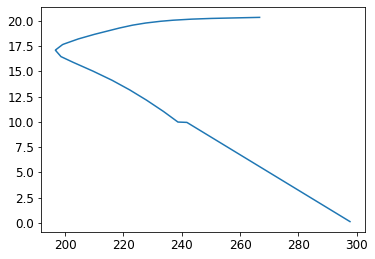

In [42]:
plt.plot(radprf.tlay[0],z)